<a href="https://colab.research.google.com/github/joelleyarro03/jupiter-exploration/blob/main/workshop_1_output.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# I.  Project Overview

<center><img src="https://github.com/patitimoner/workshop-chihuahua-vs-muffin/blob/master/resources/preview.jpg?raw=1" width="700"></center>

In this project, we'll build a neural network classifier that determines: **MUFFIN... or CHIHUAHUA!**

This is what we'll cover in the tutorial:
#### 1) Build the neural network
#### 2) Load the data
#### 3) Train the model on the data
#### 4) Visualize the results

### Remember: This is an INTERACTIVE Notebook!
You should run and play with the code as you go to see how it works. Select a cell and **press shift-enter to execute code.**

<img src="https://github.com/patitimoner/workshop-chihuahua-vs-muffin/blob/master/resources/jupyter_animated.gif?raw=1" width="700">

# II.  Deep Learning Tutorial

Let's get to the fun stuff!



<center><img src="https://github.com/patitimoner/workshop-chihuahua-vs-muffin/blob/master/resources/Pytorch_logo.png?raw=1" width="700"></center>

**Generic Python imports** (select the below cell and press shift-enter to execute it)

In [3]:
import matplotlib.pyplot as plt  # graphical library, to plot images
# special Jupyter notebook command to show plots inline instead of in a new window
%matplotlib inline

**Deep learning imports**

In [2]:
import torch                                            # PyTorch deep learning framework
from torchvision import datasets, models, transforms    # extension to PyTorch for dataset management
import torch.nn as nn                                   # neural networks module of PyTorch, to let us define neural network layers
from torch.nn import functional as F                    # special functions
import torch.optim as optim                             # optimizers

## (1) Build our Neural Network

Recall from the lesson that a neural network generally looks like this. Input is on the left, output is on the right. The number of output neurons correspond to the number of classes.

<img src="https://github.com/patitimoner/workshop-chihuahua-vs-muffin/blob/master/resources/what_is_nn_slide.jpg?raw=1" width="700">

So let's define a similar architecture for our 2-class muffin-vs-chihuahua classifier:

In [5]:
# Extends PyTorch's neural network baseclass
class MySkynet(nn.Module):
    """
    A very basic neural network.
    """
    def __init__(self, input_dim=(3, 224, 224)):
        """
        Constructs a neural network.

        input_dim: a tuple that represents "channel x height x width" dimensions of the input
        """
        super().__init__()
        # the total number of RGB pixels in an image is the tensor's volume
        num_in_features = input_dim[0] * input_dim[1] * input_dim[2]
        # input layer
        self.layer_0 = nn.Linear(num_in_features, 128)
        # hidden layers
        self.layer_1 = nn.Linear(128, 64)
        self.layer_2= nn.Linear(64, 32)
        # output layer, output size of 2 for chihuahua and muffin
        self.layer_3= nn.Linear(32, 2)

    def forward(self, x):
        """
        Define the forward pass through our network.
        """
        batch_size = x.shape[0]
        # convert our RGB tensor into one long vector
        x = x.view(batch_size, -1)

        # pass through our layers
        x = F.relu(self.layer_0(x))
        x = F.relu(self.layer_1(x))
        x = F.relu(self.layer_2(x))
        x = F.relu(self.layer_3(x))

        # convert the raw output to probability predictions
        x = F.softmax(x, dim=1)

        return x

Now that we've defined the network above, let's initialize it. If available, we'll place the network on the GPU; if not, it goes on the CPU.

In [6]:
 # cuda:0 means the first cuda device found
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MySkynet().to(device)                      # load our simple neural network
model

MySkynet(
  (layer_0): Linear(in_features=150528, out_features=128, bias=True)
  (layer_1): Linear(in_features=128, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=32, bias=True)
  (layer_3): Linear(in_features=32, out_features=2, bias=True)
)

Essentially, our network looks like this:
<img src="https://github.com/patitimoner/workshop-chihuahua-vs-muffin/blob/master/resources/architecture.png?raw=1" width="600">

## (2) Data and Data Loading

### Separate "train" and "test" datasets

Recall from the below slide, we should make two separate datasets to train and test our model. That way, we know our model learns more than rote memorization.

<center><img src="https://github.com/patitimoner/workshop-chihuahua-vs-muffin/blob/master/resources/when_is_your_model_ready_slide.jpg?raw=1" width="600"></center>

### Inspect our data
Let's look in our data folder to see what's there. As you can see, the folder is **split into "train" for training**, and **"validation" for testing** (to validate our model).

In [59]:
import os

print("Current working directory:", os.getcwd())


Current working directory: /content


Let's also look at some of the images:

Error loading image data/train/chihuahua/4.jpg: [Errno 2] No such file or directory: '/content/data/train/chihuahua/4.jpg'
Error loading image data/train/chihuahua/5.jpg: [Errno 2] No such file or directory: '/content/data/train/chihuahua/5.jpg'
Error loading image data/train/muffin/131.jpg: [Errno 2] No such file or directory: '/content/data/train/muffin/131.jpg'
Error loading image data/train/muffin/107.jpg: [Errno 2] No such file or directory: '/content/data/train/muffin/107.jpg'


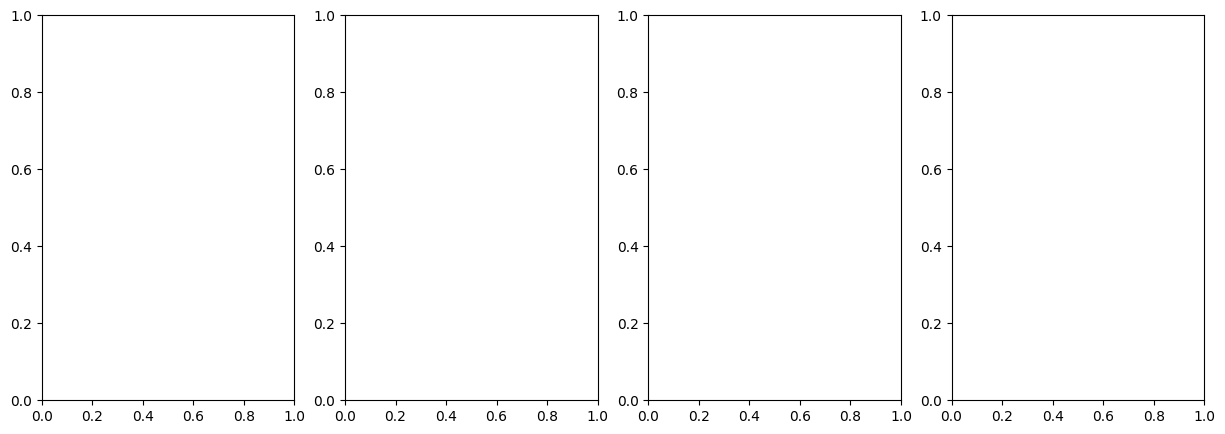

In [63]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Set up the figure to display images
_, ax = plt.subplots(1, 4, figsize=(15, 5))  # 1 row x 4 columns

# List of image paths
image_paths = [
    "data/train/chihuahua/4.jpg",
    "data/train/chihuahua/5.jpg",
    "data/train/muffin/131.jpg",
    "data/train/muffin/107.jpg"
]

for i, path in enumerate(image_paths):
    try:
        img = Image.open(path)  # Load the image
        ax[i].imshow(img)  # Show the image
        ax[i].axis('off')  # Hide axes
    except Exception as e:
        print(f"Error loading image {path}: {e}")

# Display the images
plt.show()


If you look in the data folder on your computer, there are 120 train images and 30 validation. So our data is split like this:

<img src="https://github.com/patitimoner/workshop-chihuahua-vs-muffin/blob/master/resources/folders.png?raw=1" width="600">

### Load our data

That's great that we have data! But we have to load all the images and convert them into a form that our neural network understands. Specifically, PyTorch works with **Tensor** objects. (A tensor is just a multidimensional matrix, i.e. an N-d array.)

<img src="https://github.com/patitimoner/workshop-chihuahua-vs-muffin/blob/master/resources/image_to_tensor.jpg?raw=1" width="550">


**To easily convert our image data into tensors, we use the help of a "dataloader."** The dataloader packages data into convenient boxes for our model to use. You can think of it like one person passing boxes (tensors) to another.
<img src="https://github.com/patitimoner/workshop-chihuahua-vs-muffin/blob/master/resources/dataloader_box_analogy.jpg?raw=1" width="400">

**First, we define some "transforms" to convert images to tensors.** We must do so for both our train and validation datasets.

For more information about transforms, check out the link here: https://pytorch.org/docs/stable/torchvision/transforms.html

In [9]:
normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                 std=[0.5, 0.5, 0.5])

# transforms for our training data
train_transforms = transforms.Compose([
    # resize to resnet input size
    transforms.Resize((224,224)),
    # transform image to PyTorch tensor object
    transforms.ToTensor(),
    normalize
])

# these validation transforms are exactly the same as our train transforms
validation_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize
])

print("Train transforms:", train_transforms)

Train transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
)


**Second, we create the datasets, by passing the transforms into the ImageFolder constructor.**

These just represent the folders that hold the images.

In [64]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # Add any other transformations you need
])

validation_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # Add any other transformations you need
])



**And finally, form dataloaders from the datasets:**

In [98]:
# prompt: # Create the datasets
# try:
#     image_datasets = {
#         'train': datasets.ImageFolder(train_dir, train_transforms),
#         'validation': datasets.ImageFolder(validation_dir, validation_transforms)
#     }
#     print("Datasets created successfully.")
# except Exception as e:
#     print("Error creating datasets:", e)
# # Create the DataLoaders
# try:
#     dataloaders = {
#         'train': torch.utils.data.D

train_dir = 'data/train'
validation_dir = 'data/validation'

# Create the datasets



In [121]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define paths to your dataset
data_dir = 'path/to/your/data'  # Replace with your dataset path

# Define transforms for the training and validation sets
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    'validation': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]),
}

# Create datasets
image_datasets = {
    'train': datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=data_transforms['train']),
    'validation': datasets.ImageFolder(os.path.join(data_dir, 'validation'), transform=data_transforms['validation']),
}

# Create the DataLoaders
dataloaders = {
    'train': DataLoader(
        image_datasets['train'],
        batch_size=8,
        shuffle=True,
        num_workers=4
    ),
    'validation': DataLoader(
        image_datasets['validation'],
        batch_size=8,
        shuffle=False,
        num_workers=4
    )
}

# Print DataLoader information
print("Train loader:", dataloaders["train"])
print("Validation loader:", dataloaders["validation"])

# Example to iterate through the train DataLoader
for images, labels in dataloaders["train"]:
    print("Batch of images shape:", images.size())
    print("Batch of labels shape:", labels.size())
    break  # Just show the first batch
 Create datasets
image_datasets = {
    'train': datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=data_transforms['train']),
    'validation': datasets.ImageFolder(os.path.join(data_dir, 'validation'), transform=data_transforms['validation']),
}

# Create the DataLoaders
dataloaders = {
    'train': DataLoader(
        image_datasets['train'],
        batch_size=8,
        shuffle=True,
        num_workers=4
    ),
    'validation': DataLoader(
        image_datasets['validation'],
        batch_size=8,
        shuffle=False,
        num_workers=4
    )
}


We can see a dataloader outputs 2 things: a BIG tensor to represent an image, and a vector to represent the labels (0 or 1).

In [143]:
# Get the first batch from the train DataLoader
images, labels = next(iter(dataloaders["train"]))

# Print shapes and a sample of the outputs
print("Batch of images shape:", images.size())  # e.g., torch.Size([8, 3, 224, 224])
print("Batch of labels shape:", labels.size())  # e.g., torch.Size([8])
print("Sample labels:", labels)  # Example output: tensor([0, 1, 0, 1, 1, 0, 0, 1])


## (4) Train the model!

Hurray! We've built a neural network and have data to give it. Now we **repeatedly iterate over the data to train the model.**

Every time the network gets a new example, it looks something like this. Note the **forward pass** and the corresponding **backward pass**.

<img src="https://github.com/patitimoner/workshop-chihuahua-vs-muffin/blob/master/resources/backpropagation.gif?raw=1" width="700">

### Define the train loop

We want the network to learn from every example in our training dataset. However, the best performance comes from more practice. Therefore, we **run through our dataset for multiple *epochs*.**

After each epoch, we'll check how our model performs on the validation set to monitor its progress.

In [139]:
from tqdm import tnrange, tqdm_notebook # import progress bars to show train progress

def train_model(model, dataloaders, loss_function, optimizer, num_epochs):
    """
    Trains a model using the given loss function and optimizer, for a certain number of epochs.

    model: a PyTorch neural network
    loss_function: a mathematical function that compares predictions and labels to return an error
    num_epochs: the number of times to run through the full training dataset
    """
    # train for n epochs. an epoch is a full iteration through our dataset
    for epoch in tnrange(num_epochs, desc="Total progress", unit="epoch"):
        # print a header
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('----------------')

        # first train over the dataset and update weights; at the end, calculate our validation performance
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            # keep track of the overall loss and accuracy for this batch
            running_loss = 0.0
            running_corrects = 0

            # iterate through the inputs and labels in our dataloader
            # (the tqdm_notebook part is to display a progress bar)
            for inputs, labels in tqdm_notebook(dataloaders[phase], desc=phase, unit="batch", leave=False):
                # move inputs and labels to appropriate device (GPU or CPU)
                inputs = inputs.to(device)
                labels = labels.to(device)

                # FORWARD PASS
                outputs = model(inputs)
                # compute the error of the model's predictions
                loss = loss_function(outputs, labels)

                if phase == 'train':
                    # BACKWARD PASS
                    optimizer.zero_grad()  # clear the previous gradients
                    loss.backward()        # backpropagate the current error gradients
                    optimizer.step()       # update the weights (i.e. do the learning)

                # track our accumulated loss
                running_loss += loss.item() * inputs.size(0)
                # track number of correct to compute accuracy
                _, preds = torch.max(outputs, 1)
                running_corrects += torch.sum(preds == labels.data)

            # print our progress
            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])
            print(f'{phase} error: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

        print()

### Loss function and optimizer

One last thing: we must define a function that gives feedback for how well the model performs. This is the **loss**, or "error" **function**, that compares model predictions to the true labels.

Once we calculate the error, we also need to define how the model should react to that feedback. **The optimizer determines how the network learns from feedback.**

In [140]:
loss_function = nn.CrossEntropyLoss()              # the most common error function in deep learning
optimizer = optim.SGD(model.parameters(), lr=0.1)  # Stochastic Gradient Descent, with a learning rate of 0.1

<img src="https://github.com/patitimoner/workshop-chihuahua-vs-muffin/blob/master/resources/gradient_descent.gif?raw=1" width="700">

### Run training

Let's put everything together and TRAIN OUR MODEL! =D

In [151]:

# Initialize model, loss function, and optimizer
model = SimpleModel()
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Function to train the model
def train_model(model, dataloaders, loss_function, optimizer, num_epochs=3):
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        for images, labels in dataloaders['train']:
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(images)  # Forward pass
            loss = loss_function(outputs, labels)  # Calculate loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

# Now you can call the train_model function
train_model(model, dataloaders, loss_function, optimizer, num_epochs=3)

## Examine model performance

<img src="https://github.com/patitimoner/workshop-chihuahua-vs-muffin/blob/master/resources/question_mark.jpg?raw=1" width="200" >

**How do we examine our model's predictions? Let's visualize what the model thinks on the validation set.**

In [153]:
# Make predictions
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient calculation
    pred_logits_tensor = model(validation_batch)
    pred_probs = torch.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()  # Get probabilities

# Show the probabilities for each picture
fig, axs = plt.subplots(6, 5, figsize=(20, 20))
for i, img_path in enumerate(validation_img_paths):
    if i >= 30:  # Limit to 30 images
        break
    ax = axs[floor(i / 5)][i % 5]
    ax.axis('off')
    ax.set_title("{:.0f}% Chi, {:.0f}% Muff".format(100 * pred_probs[i, 0], 100 * pred_probs[i, 1]), fontsize=18)
    ax.imshow(Image.open(img_path))

plt.tight_layout()
plt.show()

**Consider:** How accurate was your model? How confident were its predictions? Does it make clear-cut decisions?

## Congratulations! You've successfully trained a neural network!

# III.  Can You Do Better?

Now that we've shown you how to train a neural network, can you improve the validation accuracy by tweaking the parameters? **We challenge you to reach 100% accuracy!**

Some parameters to play with:
- Number of epochs
- The learning rate "lr" parameter in the optimizer
- The type of optimizer (https://pytorch.org/docs/stable/optim.html)
- Number of layers and layer dimensions
- Image size
- Data augmentation transforms (https://pytorch.org/docs/stable/torchvision/transforms.html)

# Special Thanks!

Credit for the original idea and code goes to [DeepSense.ai](https://deepsense.ai/keras-vs-pytorch-avp-transfer-learning/)!
We've modified it significantly to cater to this workshop, and boost the visual appeal.

This tutorial was created through hard work and love by Jing Zhao, Dylan Wang, Jason Do, Jason Jiang, and Andrew Jong.